<a href="https://colab.research.google.com/github/sindhu819/Projects/blob/master/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Pyspark in google collab

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [0]:
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz

In [0]:
!tar xf spark-2.4.4-bin-hadoop2.7.tgz

In [0]:
!pip install -q findspark

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

## Importing the required libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")

from pyspark.ml.linalg import DenseVector

from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.types import *

from operator import add
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import Word2Vec, Word2VecModel

from pyspark.ml.clustering import LDA, LDAModel, LocalLDAModel

from wordcloud import WordCloud




In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

importing the data google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading the Dataset from  Google Drive to python

In [0]:
file=r'drive/My Drive/Dataset/Yelp_Business.csv'
business=pd.read_csv(file)

In [0]:
file1=r'drive/My Drive/Dataset/Yelp_Users.csv'
users=pd.read_csv(file1)

## Reading the CSV files inside spark

# Business

In [0]:
business_df = spark.read.csv(file,header=True)

In [0]:
# check the dataframe schema

business_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- business_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- categories: string (nullable = true)



In [0]:
# display 10 records

business_df.show(20)

+--------------------+--------------------+--------------------+---------+-----+-----------+-------------+---------------+-----+------------+--------------------+
|         business_id|       business_name|             address|     city|state|postal_code|     latitude|      longitude|stars|review_count|          categories|
+--------------------+--------------------+--------------------+---------+-----+-----------+-------------+---------------+-----+------------+--------------------+
|PZ-LZzSlhSe9utkQY...|Carluccio's Tivol...|1775 E Tropicana ...|Las Vegas|   NV|      89119|   36.1000163|   -115.1285285|  4.0|          40|Restaurants, Italian|
|tstimHoMcYbkSC4eB...|Maria's Mexican R...|6055 E Lake Mead ...|Las Vegas|   NV|      89156|   36.1956146|   -115.0405289|  4.5|         184|Mexican, Restaura...|
|kANF0dbeoW34s2vwh...|         Dairy Queen|6125 Spring Mount...|Las Vegas|   NV|      89146|   36.1250311|   -115.2256202|  2.0|          33|Fast Food, Food, ...|
|X8mtoSxY8whtmbDlj...|

In [0]:
business_df.count()


5909

In [0]:
#creating the rdd
business_rdd = business_df.rdd

In [0]:
#display two records from rdd
business_rdd.take(2)

[Row(business_id='PZ-LZzSlhSe9utkQYU8pFg', business_name="Carluccio's Tivoli Gardens", address='1775 E Tropicana Ave, Ste 29', city='Las Vegas', state='NV', postal_code='89119', latitude='36.1000163', longitude='-115.1285285', stars='4.0', review_count='40', categories='Restaurants, Italian'),
 Row(business_id='tstimHoMcYbkSC4eBA1wEg', business_name="Maria's Mexican Restaurant & Bakery", address='6055 E Lake Mead Blvd', city='Las Vegas', state='NV', postal_code='89156', latitude='36.1956146', longitude='-115.0405289', stars='4.5', review_count='184', categories='Mexican, Restaurants, Patisserie/Cake Shop, Food, Bars, Nightlife')]

In [0]:
# create a temporary view to be used in SQL queries
business_df.createOrReplaceTempView("businesses")

In [0]:

# test SQL query: check some best reviewed restaurants

query = """
SELECT * FROM businesses ORDER BY stars DESC, review_count DESC LIMIT 30
"""

# convert the result to Pandas dataframe
spark.sql(query).toPandas()

,business_id,business_name,address,city,state,postal_code,latitude,longitude,stars,review_count,categories
0,k9b96JXlNewj36ddrce9Jw,Garden Grill,302 S Rampart Blvd,Las Vegas,NV,89145,36.1667834,-115.2861968,5.0,94,"Restaurants, Farmers Market, Street Vendors, M..."
1,J0PP9Yfzzw4-WyiZQ0JTwA,Arepa Xpress,2535 S Torrey Pines Dr,Las Vegas,NV,89146,36.143203,-115.2344,5.0,9,"Restaurants, Food Stands, Street Vendors, Colo..."
2,hllCtf6_B6D5JhM_dOK81A,Stage LV,9010 W Flamingo Rd,Las Vegas,NV,89147,36.115461,-115.2885276,5.0,9,"Food Trucks, Food, Restaurants, Breakfast & Br..."
3,ZkJRO4nYlINnXpNlR-jN6A,The Green Regime,"8751 W Charleston, Ste 120",Las Vegas,NV,89117,36.1576031,-115.2860645,5.0,9,"Juice Bars & Smoothies, Restaurants, Sandwiche..."
4,7hWNnAj4VwK6FAUBN8E8lg,EDO Gastro Tapas & Wine,"3400 S Jones Blvd, Ste 11A",Las Vegas,NV,89146,36.1273969,-115.2240685,5.0,85,"Spanish, Tapas/Small Plates, Restaurants"
5,L_rnF5qiCYSu9d1yIv5Cvw,Soul Food Cafe Express,None,Las Vegas,NV,89120,36.0833352,-115.0999753,5.0,8,"Specialty Food, Soul Food, Food Trucks, Ethnic..."
6,BW8xfC2Vxd-DnjB7UNpJ-Q,Yummy Chinese restaurant,"4825 S Rainbow Blvd, Ste 205",Las Vegas,NV,89103,36.1008769,-115.2445968,5.0,8,"Restaurants, Chinese"
7,EUskCVPgHoIGl3Ao0VUNLA,Fernandez Hot-Dogs,1959 E Charleston Blvd,Las Vegas,NV,89104,36.1589789702,-115.1222431032,5.0,8,"Food, Hot Dogs, Restaurants, Food Trucks"
8,OWkS1FXNJbozn-qPg3LWxg,Mama Napoli Pizza,None,Las Vegas,NV,89109,36.128561,-115.1711298,5.0,8,"Food, Food Trucks, Restaurants, Pizza"
9,WhYep5bRqXpaejOTH6ukbw,Subwich Alley,"9010 W Flamingo Rd, Ste A",Las Vegas,NV,89147,36.1155109,-115.2885083,5.0,7,"Burgers, Restaurants, Sandwiches, Chicken Wings"


# Loading the user data

In [0]:
users=spark.read.csv(file1,header=True)

In [0]:
users.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- yelping_since: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)
 |-- fans: string (nullable = true)
 |-- average_stars: string (nullable = true)



In [0]:
users.show()

+--------------------+---------+------------+-------------------+------+-----+-----+----+-------------+
|             user_id|user_name|review_count|      yelping_since|useful|funny| cool|fans|average_stars|
+--------------------+---------+------------+-------------------+------+-----+-----+----+-------------+
|-1zQA2f_syMAdA04P...|     Zach|           7|2014-06-22 02:44:41|     7|    3|    0|   0|         3.29|
|-2Pb5d2WBPtbyGT_b...|    mindy|           6|2009-04-29 14:35:45|     6|    0|    0|   0|          3.5|
|-3bsS2i9xqjNnIA1f...|      Kim|          16|2012-04-10 22:25:58|    22|    5|    1|   1|         2.39|
|-3i9bhfvrM3F1wsC9...|    Linda|         652|2005-08-07 03:08:12|  3494| 2204| 2974|  97|         4.07|
|-47g7LR58tpHlm7Bm...|     Kady|          36|2013-12-21 19:26:35|    13|    0|    1|   0|         4.55|
|-4xyc3OgPwrLshmqH...|     Sean|          45|2016-06-05 19:18:07|    14|    3|    4|   2|         4.66|
|-7V6r0PLuBlFVjbLJ...|  Michael|           4|2015-01-01 04:19:08

In [0]:
users.count()

395843

In [0]:
# create a user view for SQL queries

users.createOrReplaceTempView("users")

In [0]:
# get top 10 users based in their useful reviews

query = """
SELECT user_id, user_name, review_count, yelping_since, useful, funny,  cool, fans, average_stars
FROM users
ORDER BY useful DESC
LIMIT 10
"""

spark.sql(query).toPandas()



,user_id,user_name,review_count,yelping_since,useful,funny,cool,fans,average_stars
0,rC2PCfLaztmkZSx_VeVkxQ,Jojo,503,2007-12-04 18:30:28,999,384,462,34,3.97
1,Vq4QTo36pZSu3yNLm7BT0w,Isabel,410,2008-11-04 18:48:27,999,395,648,52,3.65
2,W7iLDP6GY4joKZ1zSCOEfA,Janine,644,2011-06-30 09:02:39,999,221,433,26,3.85
3,NJVvh5XZwb7x4pVcNlcFSg,Noel,371,2012-09-05 00:12:16,999,166,682,14,3.57
4,RhM7uTY_KwlQyq9tzP7GFA,Sean,314,2009-12-06 23:01:40,999,664,830,54,4.1
5,2tAVBVwMF2KqQNVfpT_Ulw,Jenny,314,2009-03-22 04:48:17,999,452,358,23,3.38
6,glCZpRr0LSMssbkOYGXpbQ,Kemi,711,2012-01-31 13:09:49,999,325,413,28,4.14
7,ElFXwD7NXiucNzTC-LY8eQ,Karen,224,2011-12-26 08:48:47,999,437,764,52,4.21
8,rCx7tb3toOJUsvdOeqYY0g,Sharon,1126,2009-01-20 00:35:09,9972,5384,7588,167,3.75
9,Vparw0ZG22k1s7Xhc02nxw,Jon,275,2007-09-25 20:19:12,997,429,801,28,3.28


## Loading  the friends data

In [0]:
file3=r'drive/My Drive/Dataset/Friends_Data/Yelp_Friends1.csv'
file4=r'drive/My Drive/Dataset/Friends_Data/Yelp_Friends2.csv'
file5=r'drive/My Drive/Dataset/Friends_Data/Yelp_Friends3.csv'
file6=r'drive/My Drive/Dataset/Friends_Data/Yelp_Friends4.csv'

friends1=spark.read.csv(file3,header=True)
friends2=spark.read.csv(file4,header=True)
friends3=spark.read.csv(file5,header=True)
friends4=spark.read.csv(file6,header=True)

friends1.count()

7291668

In [0]:
friends_1 = friends1.union(friends2)
friends_2=friends3.union(friends4)

In [0]:
friends=friends_1.union(friends_2)
friends.count()

29166583

In [0]:
friends.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- friend_id: string (nullable = true)



In [0]:
friends.show()

+--------------------+--------------------+
|             user_id|           friend_id|
+--------------------+--------------------+
|bytuN2o7fmHug9GZX...|6m3e_Oo_pdpA-rCxv...|
|4ZfcCa4m5RWvO4EFz...|vhDXdBeje8e7xYIIF...|
|bMOTnVsvHkVEzSBlN...|bwsFjXKJAdXPMzaj1...|
|BNuPibT74jf8Kp47b...|-BevLRnJhh9JeIT2g...|
|4mkYPmYB3AthX1FBC...|2BxskQsdpxHvCSdRD...|
|uh0Q3_oH6i7ZGN8wg...|zkIuzFo3NdPby17Zw...|
|0AlnetQ_-a4f7kY0S...|mFwRTTDW0Yr-rFkTF...|
|C2YRjTezIGFYVO0JZ...|3ZYUbNKFfg_BX3fyr...|
|9zEcqne6y-tYLDiJw...|E6jMRNIPeaIktSbxE...|
|V7LRNklGj_YAOIU5H...|jc0qzH7mcxvY4cGJf...|
|Zratk2K3CMsgLusfn...|Bnmxb2ZKLipdwcOam...|
|RQTO4aWxWEgkgjVtN...|xYgo3qYXcYlHJ84Tg...|
|okmjuDrjoFiyBTGow...|QwkydNiT4gsNUUIDP...|
|UEf2XkLwnIj4nEZyn...|XN2FoIQoh4LtoNCmk...|
|Ha5bMb0SfRcvX7CS0...|qXdOCZwY2Wi8ECIDi...|
|P6E64WfXgZpBzxKNp...|LGulEhJyXF3Lgk-_Z...|
|vzNR_IEiK4hckOIrr...|G1xLdynxZ2C4ss2zd...|
|zzEqxNW1tepmH4rl8...|pXORVE1eeGvTGycLl...|
|H7_QmS05uaYPOuwqn...|8f-9Dicz6rcurpDMq...|
|jytR6GWHr2LEO39hI...|kifkFiU8Yw

## Loading the reviews data

In [0]:
review_file=r'drive/My Drive/Dataset/Yelp_Reviews.parquet'
reviews=spark.read.parquet(review_file)

In [0]:
reviews.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- cool: long (nullable = true)



In [0]:
reviews.show()

+--------------------+--------------------+--------------------+-----+-------------------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|        review_date|         review_text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+-------------------+--------------------+------+-----+----+
|IByf6mVY0WA838XNS...|3CJUJILq7CLHk_9Or...|I4Nr-MVc26qWr08-S...|  4.0|2016-01-17 05:26:22|The food is alway...|     0|    0|   0|
|S337tATeouQJdoPYy...|2mxBNBeFrgDszqGS5...|d_L-rfS1vT3JMzgCU...|  5.0|2016-07-25 03:57:19|Pick any meat on ...|     0|    0|   0|
|D_UvaenM25iNd6aeh...|8NwU4TRsD3S6gIfBq...|Sfc8Haz2Yri8Mo1L0...|  5.0|2012-11-06 03:41:43|Great food, great...|     0|    0|   0|
|qm97yMwREr7BKkexl...|TTRVdTXKcq-xn6-1I...|Gyrez6K8f1AyR7dzW...|  5.0|2013-12-28 22:28:08|their pettuccine ...|     0|    0|   1|
|0AsmPiAQduxh5jE_s...|C_hUvw2z0R-Rv0yZb...|dm6sO_Y8JdKTE1ZM9...|  5.0|2014-12-17 19:04:33|

In [0]:
reviews.count()

1076129

In [0]:

reviews.createOrReplaceTempView("reviews")


query = """
select sum(stars_count) from (SELECT
    r.business_id, b.business_name,
    COUNT(*) as stars_count
FROM reviews r 
INNER JOIN businesses b ON b.business_id = r.business_id
GROUP BY r.business_id, b.business_name
ORDER BY COUNT(*) ASC
LIMIT 3200)
"""
k=spark.sql(query).toPandas()
k

,sum(stars_count)
0,74774


Text(0.5, 1.0, 'Review Rating Count')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21213 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 35352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 21213 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 35352 missing from current font.
  font.set_text(s, 0, flags=flags)


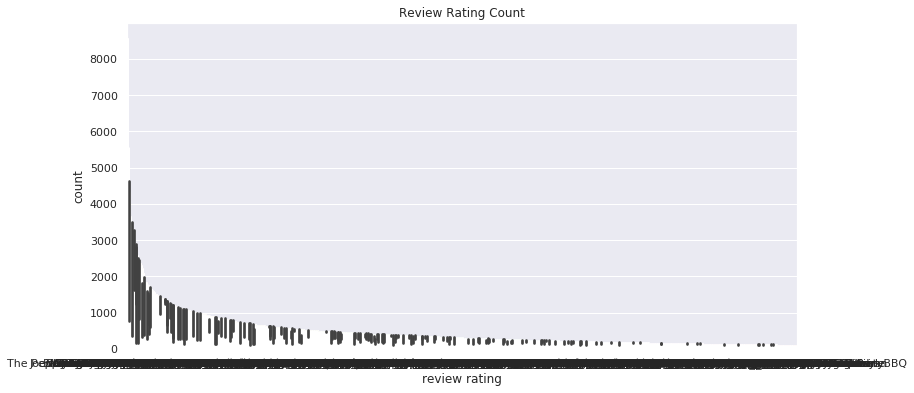

In [0]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='business_name', y='stars_count', data=k, ax=ax)
ax.set_xlabel('review rating')
ax.set_ylabel('count')
ax.set_title('Review Rating Count')

In [0]:
#

In [0]:
# create a review view to be used in SQL queries

reviews.createOrReplaceTempView("reviews")

In [0]:
query = """
SELECT
    r.business_id, b.business_name,
    COUNT(*) as 5_stars_count
FROM reviews r 
INNER JOIN businesses b ON b.business_id = r.business_id
WHERE r.stars = '5' and review_date >= '2018-02-23 23:07:48'
GROUP BY r.business_id, b.business_name
ORDER BY COUNT(*) DESC
LIMIT 10
"""


# run the query and convert the results into Pandas dataframe
spark.sql(query).toPandas()

,business_id,business_name,5_stars_count
0,vHz2RLtfUMVRPFmd7VBEHA,Gordon Ramsay Hell's Kitchen,1175
1,QXV3L_QFGj8r6nWX2kS2hA,Nacho Daddy,744
2,faPVqws-x-5k2CQKDNtHxw,Yardbird Southern Table & Bar,726
3,mDR12Hafvr84ctpsV6YLag,Mr Mamas,516
4,4JNXUYY8wbaaDmk3BPzlWw,Mon Ami Gabi,439
5,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,428
6,hihud--QRriCYZw1zZvW4g,Gangnam Asian BBQ Dining,403
7,IWN2heYitkg-D4UdqfxcMA,HEXX kitchen + bar,402
8,xfWdUmrz2ha3rcigyITV0g,Gordon Ramsay Burger,355
9,N0CoaG3cBrTGm2ecLYSzqA,Lotus of Siam,355


In [0]:
query = """
SELECT date_format(review_date, 'yyyy-MM') review_month,
stars, COUNT(*) stars_count
FROM reviews
GROUP BY date_format(review_date, 'yyyy-MM'), stars
ORDER BY 1,2
"""

# run the query and convert the results into Pandas dataframe
df_review_summary = spark.sql(query).toPandas()
df_review_summary.tail(10)


,review_month,stars,stars_count
793,2018-10,1.0,2095
794,2018-10,2.0,1081
795,2018-10,3.0,1493
796,2018-10,4.0,2914
797,2018-10,5.0,8253
798,2018-11,1.0,1100
799,2018-11,2.0,518
800,2018-11,3.0,678
801,2018-11,4.0,1359
802,2018-11,5.0,4030


In [0]:
df_review_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 3 columns):
review_month    803 non-null object
stars           803 non-null float64
stars_count     803 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 18.9+ KB


In [0]:
df_review_summary[df_review_summary.review_month.isnull()]

,review_month,stars,stars_count


In [0]:
# change the review_month data type to Date
df_review_summary["review_date"] = df_review_summary.review_month + '-01'
df_review_summary["review_month"] = df_review_summary.review_date.astype('datetime64[ns]')
df_review_summary.drop('review_date', axis=1, inplace=True)
df_review_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 3 columns):
review_month    803 non-null datetime64[ns]
stars           803 non-null float64
stars_count     803 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 18.9 KB


Text(0.5, 1.0, 'Review Rating Count')

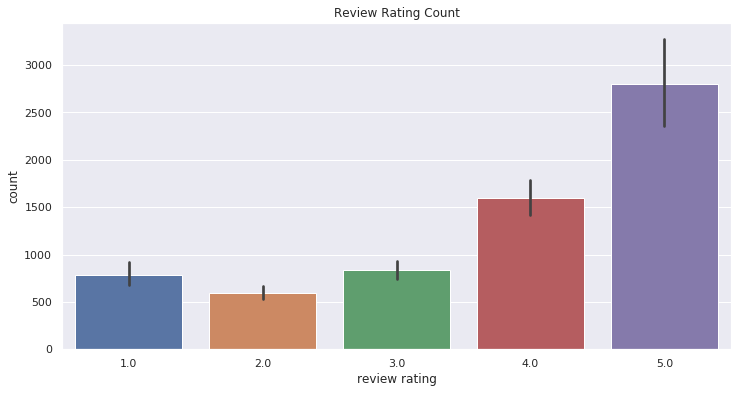

In [0]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='stars', y='stars_count', data=df_review_summary, ax=ax)
ax.set_xlabel('review rating')
ax.set_ylabel('count')
ax.set_title('Review Rating Count')


___people tend to rate in the range of 4 an 5 stars___

Text(0.5, 1.0, 'Review Count History')

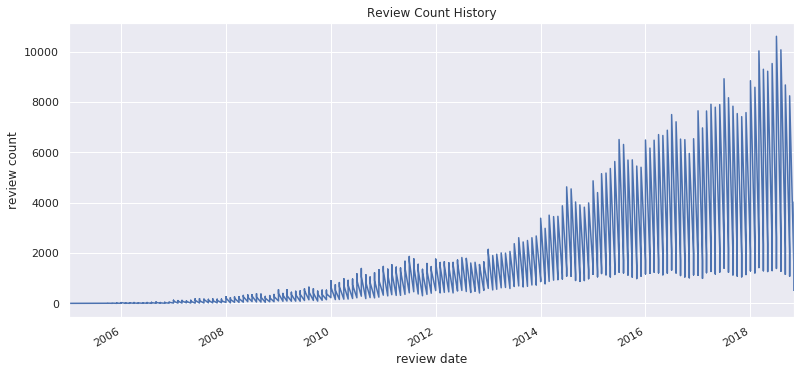

In [0]:
fig, ax = plt.subplots(figsize=(13, 6))

df_review_summary.plot(kind='line', x='review_month', y='stars_count', legend=False, ax=ax)
ax.set_xlabel('review date')
ax.set_ylabel('review count')
ax.set_title('Review Count History')


## Reviews are increasing over time ... more people are using the Yelp system 


Text(0.5, 1.0, 'Review Ratings History')

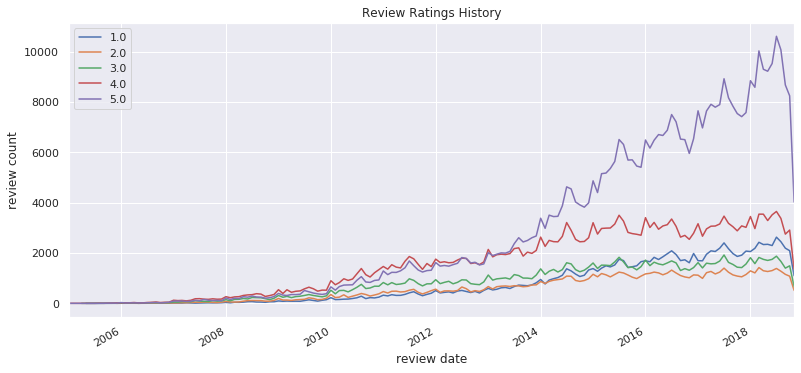

In [0]:
fig, ax = plt.subplots(figsize=(13, 6))

labels = []
for key, grp in df_review_summary.groupby(['stars']):
    ax = grp.plot(ax=ax, kind='line', x='review_month', y='stars_count')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
ax.set_xlabel('review date')
ax.set_ylabel('review count')
ax.set_title('Review Ratings History')



In [0]:
# show some bad review text from the SQL view

query = """
SELECT
    review_text
FROM reviews
WHERE stars = 1
LIMIT 10
"""

bad_review_sample = spark.sql(query).rdd.take(1)[0][0]
print('bad review sample: \n\n' + bad_review_sample)

bad review sample: 

We had dinner at the Bellagio Buffet last night. The service was OK. Our server was great but kind of forgot about us towards the end of our visit. The food was cold. The only good thing there was the crab legs because they're suppose to be cold and the tacos because it was freshly made. The food was under a single lamp that didn't heat the food at all. We let the server know that the food was cold and he told the manager that was in charge. All she did was come over to ask what the problem was and said she was going to talk to the chief. Have no idea what actually happened though because we didn't see her after that. Half the buffet was closed as well so there wasn't that many options. I must say i rather go to the Rio buffet. For a high end casino this was a horrible experience.


In [0]:
# show some good review text from the SQL view

query = """
SELECT
    review_text
FROM reviews
WHERE stars = 5
LIMIT 10
"""

good_review_sample = spark.sql(query).rdd.take(1)[0][0]
print('good review sample: \n\n' + good_review_sample)

good review sample: 

Pick any meat on the planet and the chef will make a Mexican style dish with amazing flavor! Wow, fish and lamb tacos to die for. Drinks are great as well.


## Text Preprocessing and Analysis

Since the review text will be used to build the features for the content-filtering based recommendation, the following steps will be performed to analyse the reviews:

- Concatenate review text for each business
- Tokenize concatenated text
- Remove stop words from the Tokens
- Perform some Topic Modeling
- Word cloud


##### Concatenate review text for each business

In [0]:
# create review text dataframe

reviews_text = spark.sql("SELECT business_id, review_text FROM reviews")

In [0]:
reviews_text.show(3)


+--------------------+--------------------+
|         business_id|         review_text|
+--------------------+--------------------+
|I4Nr-MVc26qWr08-S...|The food is alway...|
|d_L-rfS1vT3JMzgCU...|Pick any meat on ...|
|Sfc8Haz2Yri8Mo1L0...|Great food, great...|
+--------------------+--------------------+
only showing top 3 rows



In [0]:
# create RDD from review text dataframe and use it to concatenate the text for each business

reviews_text_rdd = reviews_text.rdd
reviews_by_business_rdd = reviews_text_rdd.map(tuple).reduceByKey(add)  
reviews_by_business_df = spark.createDataFrame(reviews_by_business_rdd)
reviews_by_business_df = reviews_by_business_df \
                            .withColumnRenamed('_1', 'business_id') \
                            .withColumnRenamed('_2', 'text')
reviews_by_business_df.count()   

5909

In [0]:
reviews_by_business_df.show(3)

+--------------------+--------------------+
|         business_id|                text|
+--------------------+--------------------+
|eoyvbnRYQe-z85e8R...|We had dinner her...|
|6xgcHeLad-VaoTIQe...|ooooooh yummy.  i...|
|YF4QJ_j-PM7cMZja6...|What an awesome p...|
+--------------------+--------------------+
only showing top 3 rows



In [0]:
# create tokens from review text


regexTokenizer = RegexTokenizer(gaps = False, pattern = '\w+', inputCol = 'text', outputCol = 'token')

reviews_by_business_token_df = regexTokenizer.transform(reviews_by_business_df)
reviews_by_business_token_df.show(3)

+--------------------+--------------------+--------------------+
|         business_id|                text|               token|
+--------------------+--------------------+--------------------+
|eoyvbnRYQe-z85e8R...|We had dinner her...|[we, had, dinner,...|
|6xgcHeLad-VaoTIQe...|ooooooh yummy.  i...|[ooooooh, yummy, ...|
|YF4QJ_j-PM7cMZja6...|What an awesome p...|[what, an, awesom...|
+--------------------+--------------------+--------------------+
only showing top 3 rows



In [0]:
# remove stop words from tokens

stopWordsRemover = StopWordsRemover(inputCol = 'token', outputCol = 'nostopwrd')

reviews_by_business_token_nostopwrd_df = stopWordsRemover.transform(reviews_by_business_token_df)
reviews_by_business_token_nostopwrd_df.show(3)

+--------------------+--------------------+--------------------+--------------------+
|         business_id|                text|               token|           nostopwrd|
+--------------------+--------------------+--------------------+--------------------+
|eoyvbnRYQe-z85e8R...|We had dinner her...|[we, had, dinner,...|[dinner, food, ex...|
|6xgcHeLad-VaoTIQe...|ooooooh yummy.  i...|[ooooooh, yummy, ...|[ooooooh, yummy, ...|
|YF4QJ_j-PM7cMZja6...|What an awesome p...|[what, an, awesom...|[awesome, pool, p...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



##### TF-IDF Featurization

In [0]:
# create vectors (features)

countVectorizer = CountVectorizer(inputCol="nostopwrd", outputCol="rawFeature")
cv_model = countVectorizer.fit(reviews_by_business_token_nostopwrd_df)
reviews_by_business_featurized_df = cv_model.transform(reviews_by_business_token_nostopwrd_df)

# get the vovablary  (all words)
vocab = cv_model.vocabulary

reviews_by_business_featurized_df.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|         business_id|                text|               token|           nostopwrd|          rawFeature|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|eoyvbnRYQe-z85e8R...|We had dinner her...|[we, had, dinner,...|[dinner, food, ex...|(260453,[0,1,2,3,...|
|6xgcHeLad-VaoTIQe...|ooooooh yummy.  i...|[ooooooh, yummy, ...|[ooooooh, yummy, ...|(260453,[0,1,2,3,...|
|YF4QJ_j-PM7cMZja6...|What an awesome p...|[what, an, awesom...|[awesome, pool, p...|(260453,[0,1,2,3,...|
+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [0]:
# create features using IDF (Inverse Document Frequency)

iDF = IDF(inputCol="rawFeature", outputCol="idf_vec")
idf_model = iDF.fit(reviews_by_business_featurized_df)
reviews_by_business_rescaled_df = idf_model.transform(reviews_by_business_featurized_df) 

reviews_by_business_rescaled_df.select('business_id','nostopwrd','rawFeature', 'idf_vec').show(3)

##### Word2Vec Featurization

In [0]:
# create features using Word2Vec -- very resource intensive operation
model_path='drive/My Drive/Dataset/Model'
word2Vec = Word2Vec(vectorSize = 100, minCount = 5, inputCol = 'nostopwrd', outputCol = 'word_vec')
word2Vec_model = word2Vec.fit(reviews_by_business_token_nostopwrd_df)

# save the word2vec model
word2Vec_model.write().overwrite().save(model_path + 'word2Vec')


In [0]:
# load the word2vec trained model

word2Vec_mdl = Word2VecModel.load(model_path + 'word2Vec')

In [0]:
# create word2vec vectors from nostopwrd

reviews_by_business_vec_df = word2Vec_mdl.transform(reviews_by_business_rescaled_df)
reviews_by_business_vec_df.select('business_id','nostopwrd','rawFeature', 'idf_vec', 'word_vec').show(3)


In [0]:
reviews_by_business_vec_df.select('business_id','text', 'token','nostopwrd', 'idf_vec', 'word_vec').limit(3).toPandas()

##### Test Word2Vec


In [0]:
word2Vec_mdl.findSynonyms('chinese', 5).show()

In [0]:
word2Vec_mdl.findSynonyms('good', 5).show()

In [0]:
word2Vec_mdl.findSynonyms('tacos', 5).show()

### Topic Modelling


In [0]:
# create LDA model -- very resource intensive operation
model_path='drive/My Drive/Dataset/Model'
lDA = LDA(k=10, seed=123, optimizer='online', featuresCol='rawFeature')
lda_model = lDA.fit(reviews_by_business_rescaled_df)

# save the lda model
lda_model.write().overwrite().save(model_path + 'lda')

In [0]:
#load the LDA_model

lda_mdl = LocalLDAModel.load(model_path + 'lda')


In [0]:
ldatopics = lda_mdl.describeTopics()

ldatopics.show(10)

In [0]:
# show the topics

topics = lda_mdl.describeTopics()
topics_rdd = topics.rdd
topics_words = topics_rdd\
       .map(lambda row: row['termIndices'])\
       .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
       .collect()

for idx, topic in enumerate(topics_words):

    print("---------")
    
    topic_words = ''
    
    for word in topic:
        topic_words = topic_words + ' ' + word
    print("topic: "+ str(idx) + ': ' + topic_words)

In [0]:
# add the token count 

token_len = udf(lambda s: len(s), IntegerType())

reviews_by_business_vec_df = reviews_by_business_vec_df \
                                .withColumn("token_cnt", token_len(reviews_by_business_vec_df.nostopwrd))
reviews_by_business_vec_df.select('business_id','nostopwrd','rawFeature', 'idf_vec', 'word_vec', 'token_cnt').show(2)

In [0]:
# create a business_summary dataframe to be used for furher analysis

a = reviews_by_business_vec_df.alias("a")
b = business_df.alias("b")
    
bus_summary = a.join(b, col("a.business_id") == col("b.business_id"), 'inner') \
             .select([col('a.'+xx) for xx in a.columns] + [col('b.business_name'),col('b.categories'),
                                                           col('b.stars'),col('b.review_count'),
                                                           col('b.latitude'),col('b.longitude')])

bus_summary.select('business_id', 'business_name','nostopwrd', 'idf_vec', 'word_vec', 'token_cnt').show(10)    

## Why Topic Modelling


